<h1>Capstone Project - The Battle of the Neighborhoods (Week 2)</h1>
<h3>Applied Data Science Capstone by IBM/Coursera</h3>
<br />
<h1><u>The Best Neighborhood for Dog Walking in Toronto</u></h1>

<h2>Table of contents<a class="anchor-link" href="#Table-of-contents">&#182;</a></h2><ul>
<li><a href="#introduction">Introduction: Business Problem</a></li>
<li><a href="#data">Data</a></li>
<li><a href="#methodology">Methodology</a></li>
<li><a href="#results">Results</a></li>
<li><a href="#discussion">Discussion</a></li>
<li><a href="#conclusion">Conclusion</a></li>
</ul>

<h2 id="Introduction:-Business-Problem-">Introduction: Business Problem <a name="introduction" /><a class="anchor-link" href="#Introduction:-Business-Problem-">&#182;</a></h2>

A client wants to start a dog walking business in Toronto and has asked for advice about where it should be located.  In this project we will try to find the optimal location for a dog walker to center their business.  Dog walkers spend a lot of time picking up and dropping off dogs.  Ideally we want to target an area with a large number of pets as well as a large number of places to walk them. That way we can minimize the amount of time the dog walker spends driving between dog walking clients, and the amount of time driving the dogs to their walking location. 

To do this analysis, we will use the following information:
- The name and population of each neighborhood in Toronto.
- The number of pets in each neighborhood.
- The number of appropriate venues for walking dogs in each neighborhood (trails, parks and dog runs).

Using the above information, we will
- Look at the proportion of pets/population in each neighborhood.
- Cluster neighborhoods to find areas with a relatively high number of pet licenses and high number of dog related venues.

<h2 id="Data-">Data <a name="data" /><a class="anchor-link" href="#Data-">&#182;</a></h2>

<p>The following data sources will be needed to extract/generate the required information:</p>
<ul>
    <li><b>Population by Postal Code from Census 2016:</b> <a href="https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/comprehensive.cfm">https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/comprehensive.cfm</a>
        <ul><li> This information will be used to calculate the proportion of pet ownership in each neighborhood of Toronto.</li>
        <li> We will use the 3 columns: FSA, Province and Population, 2016.</li>
            <li>The FSA is the "forward sortation area" or first three digits of the postal code.<p>&nbsp;</p></li>
        </ul>
    </li>
    <li><b>Toronto Open Data: Licensed Dogs and Cats Reports for 2013 through 2017 </b><a href="https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/community-services/#a666d03a-bafe-943a-e256-3c2d14b07b10">https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/community-services/#a666d03a-bafe-943a-e256-3c2d14b07b10</a>
        <ul><li>
        This data has four columns: FSA / # Cat Licenses Issued / # Dog Licenses Issued / Total Licenses.<p>&nbsp;</p></li>
        </ul></li>
    <li><b>FourSquare Api: </b>
        <ul><li> We will query to get the number of places to walk a dog per neighborhood in Toronto.</li><li>
 Specifically, this query will be filtered to look for only the following category Ids:<ul><li>
        Dog Run 4bf58dd8d48988d1e5941735</li><li>
        Park 4bf58dd8d48988d163941735</li><li>
        Trail 4bf58dd8d48988d159941735</li></ul></li><li>
 A sample query looks like this:
https://api.foursquare.com/v2/venues/explore?client_id=<id>&client_secret=<secret>E&v=X&ll=43.642960,-79.371613
&radius=400&limit=100&categoryId=4bf58dd8d48988d1e5941735,4bf58dd8d48988d163941735,4bf58dd8d48988d159941735
       <p>&nbsp;</p> </li></ul>
            <li><b>geopy:</b> <ul><li>
    We will use this to get coordinates for each postal code, for use when calling the Foursquare API.<p>&nbsp;</p></li></ul></li>

<li><b>Wikipedia: </b><a href="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" >https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M</a><ul><li>
    We will use this to get the neighborhood name for each FSA.<p>&nbsp;</p></li></ul></li></ul>
    
<h3 id="Neighborhoods">Gathering and Cleaning Data</h3><p><h4>Toronto Neighborhood Data</h4></p><p>Let's find the latitude &amp; longitude coordinates for each of our candidate neighborhoods in Toronto.  We'll do this by first scraping the neighborhood FSA, or postal code, data from Wikipedia into a pandas dataframe.  Next we'll load the coordinates for those postal codes from geopy into another dataframe.  Finally, we'll merge the two dataframes into a single dataframe which will contain the coordinates, neighborhood name and postal code for each neighborhood in Toronto.
</p>

In [71]:
#install and import necessary packages
!conda install -c conda-forge folium=0.5.0 --yes
!pip install geocoder
!pip install lxml
!conda install -c conda-forge altair vega_datasets notebook vega -y

import pandas as pd
import numpy as np
from scipy import stats
import html5lib
import lxml
import requests
import bs4 as bs
from bs4 import BeautifulSoup
import folium # map rendering library
import geocoder

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import urllib
import matplotlib.pyplot as plt

import altair as alt
alt.renderers.enable('notebook') # show and interact ith plots in jupyter notebook

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#define the URL we will be scraping
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(website_url,'lxml')

#find table with postal code info
My_table = soup.find('table',{'class':'wikitable sortable'})

#parse table html
rows = My_table.findAll('tr')
parsed_table_data = []

for row in rows:
    children = row.findChildren(recursive=False)
    row_text = []
    for child in children:
        clean_text = child.text
        #This is to discard reference/citation links
        clean_text = clean_text.split('&#91;')[0]
        #This is to clean the header row of the sort icons
        clean_text = clean_text.split('&#160;')[-1]
        clean_text = clean_text.strip()
        row_text.append(clean_text)
    parsed_table_data.append(row_text)
    
#put the table data into a dataframe
df = pd.DataFrame(parsed_table_data[1:],columns=parsed_table_data[0])

#if neighbourhood Not Assigned, then neighbourhood=borough
df['Neighbourhood'] = df['Neighbourhood'].replace("Not assigned", df['Borough'])

#remove rows with Borough not assigned
df2 = df[df.Borough != "Not assigned"]

#merge rows with the same post code
df3=df2.groupby(['Postcode','Borough'])['Neighbourhood'].apply(','.join).reset_index()

#download geospatial coordinates
!wget -O Geospatial_coordinates.csv https://cocl.us/Geospatial_data/Geospatial_coordinates.csv

#read CSV into dataframe
GCdf = pd.read_csv('Geospatial_coordinates.csv')

#merge coordinate dataframe with neighborhood dataframe
GCdf.rename(columns={'Postal Code': 'Postcode'}, inplace=True)
result = pd.merge(df3,
                 GCdf[['Postcode', 'Latitude', 'Longitude']],
                 on='Postcode')

#check the first few rows of the dataframe 
result.head()

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

--2019-08-23 21:35:20--  https://cocl.us/Geospatial_data/Geospatial_coordinates.csv
Resolving cocl.us (cocl.us)... 169.48.113.201
Connecting to cocl.us (cocl.us)|169.48.113.201|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2019-08-23 21:35:20--  https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.box.com (ibm.box.com)... 107.152.27.197, 107.152.26.197
Connecting to ibm.box.com (ibm.box.com)|107.152.27.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2019-08-23 21:35:20--  https://ibm.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Reusing existing connection to ib

Postcode      Borough                         Neighbourhood   Latitude  \
0      M1B  Scarborough                         Rouge,Malvern  43.806686   
1      M1C  Scarborough  Highland Creek,Rouge Hill,Port Union  43.784535   
2      M1E  Scarborough       Guildwood,Morningside,West Hill  43.763573   
3      M1G  Scarborough                                Woburn  43.770992   
4      M1H  Scarborough                             Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

<p><h4>Population data from 2016 census</h4></p><p>Next we'll load the population data from the 2016 census and add that to our above dataframe, so we have the population for each neighborhood.

In [72]:
#download 2016 census dataset
df_pop = pd.read_csv("https://raw.githubusercontent.com/xanabobana/Coursera_Capstone/master/T101EN.CSV")

#keep only the columns we are interested in
df_pop=df_pop[['Geographic code','Population, 2016']]

#get rid of nan rows
nan_rows = df_pop[df_pop['Population, 2016'].isnull()]

# drop any null values 
df_pop=df_pop.dropna()

# rename columns to match our other datasets
df_pop= df_pop.rename(columns={'Geographic code': 'Postcode', 'Population, 2016': 'Pop'})

#merge population dataframe with neighborhood dataframe
toronto_merged = result.join(df_pop.set_index('Postcode'),on='Postcode')

toronto_merged.head()

Postcode      Borough                         Neighbourhood   Latitude  \
0      M1B  Scarborough                         Rouge,Malvern  43.806686   
1      M1C  Scarborough  Highland Creek,Rouge Hill,Port Union  43.784535   
2      M1E  Scarborough       Guildwood,Morningside,West Hill  43.763573   
3      M1G  Scarborough                                Woburn  43.770992   
4      M1H  Scarborough                             Cedarbrae  43.773136   

   Longitude      Pop  
0 -79.194353  66108.0  
1 -79.160497  35626.0  
2 -79.188711  46943.0  
3 -79.216917  29690.0  
4 -79.239476  24383.0

<h3>Load the Toronto Open Data Pet Licensing data set</h3><p>Next we will load and clean the pet licencing data from 2017 and add that to our dataframe as well.

In [73]:
#download pet license dataset
!wget -O 2017_dog_and_cat_licence_FSA.xls https://www.toronto.ca/ext/open_data/catalog/data_set_files/2017_dog_and_cat_licence_FSA.xls

#read xls into dataframe
df_pets = pd.read_excel('2017_dog_and_cat_licence_FSA.xls')

df_pets.head()

--2019-08-23 21:35:38--  https://www.toronto.ca/ext/open_data/catalog/data_set_files/2017_dog_and_cat_licence_FSA.xls
Resolving www.toronto.ca (www.toronto.ca)... 143.204.158.23, 143.204.158.75, 143.204.158.59, ...
Connecting to www.toronto.ca (www.toronto.ca)|143.204.158.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32256 (32K) [application/vnd.ms-excel]
Saving to: ‘2017_dog_and_cat_licence_FSA.xls’

100%[======================================>] 32,256      --.-K/s   in 0.001s  

2019-08-23 21:35:39 (40.6 MB/s) - ‘2017_dog_and_cat_licence_FSA.xls’ saved [32256/32256]



Number of Licenced Cats and Dogs By Forward Sorting Area (FSA). \n  \
0  Valid Records for period of  January 01, 2017 ...                   
1                                                FSA                   
2                                                M1B                   
3                                                M1C                   
4                                                M1E                   

  Unnamed: 1 Unnamed: 2 Unnamed: 3  
0        NaN        NaN        NaN  
1        CAT        DOG      Total  
2        285        627        912  
3        297        775       1072  
4        467        963       1430

In [74]:
#drop the first row and use the second as the column names
df_pets.columns = df_pets.iloc[1]
df_pets = df_pets.reset_index(drop=True)
df_pets.drop([0,1],axis=0,inplace=True)
df_pets.head()

1  FSA  CAT  DOG Total
2  M1B  285  627   912
3  M1C  297  775  1072
4  M1E  467  963  1430
5  M1G  220  385   605
6  M1H  155  309   464

In [75]:
# check for nulls
df_pets.isnull().any()

1
FSA      False
CAT      False
DOG      False
Total    False
dtype: bool

In [76]:
# drop null rows
df_pets=df_pets.dropna()

# we can immediately drop the columns we're not interested in 
df_pets=df_pets[['FSA','DOG']]

# rename columns to match our other datasets
df_pets=df_pets.rename(columns={'FSA': 'Postcode'})

df_pets.head()

1 Postcode  DOG
2      M1B  627
3      M1C  775
4      M1E  963
5      M1G  385
6      M1H  309

In [77]:
#join two datasets on the Postcode column
toronto_merged = toronto_merged.join(df_pets.set_index('Postcode'),on='Postcode')
toronto_merged.head()

Postcode      Borough                         Neighbourhood   Latitude  \
0      M1B  Scarborough                         Rouge,Malvern  43.806686   
1      M1C  Scarborough  Highland Creek,Rouge Hill,Port Union  43.784535   
2      M1E  Scarborough       Guildwood,Morningside,West Hill  43.763573   
3      M1G  Scarborough                                Woburn  43.770992   
4      M1H  Scarborough                             Cedarbrae  43.773136   

   Longitude      Pop  DOG  
0 -79.194353  66108.0  627  
1 -79.160497  35626.0  775  
2 -79.188711  46943.0  963  
3 -79.216917  29690.0  385  
4 -79.239476  24383.0  309

<h4>Cleanup</h4><p>Now we will do one last check of our merged data and get rid of any outliers.

In [78]:
toronto_merged.isnull().any()

Postcode         False
Borough          False
Neighbourhood    False
Latitude         False
Longitude        False
Pop               True
DOG               True
dtype: bool

In [79]:
#sanity check for the NaN values
nan_rows = toronto_merged[toronto_merged['DOG'].isnull()]
nan_rows

Postcode           Borough  \
60      M5K  Downtown Toronto   
61      M5L  Downtown Toronto   
70      M5X  Downtown Toronto   
85      M7A      Queen's Park   
86      M7R       Mississauga   
87      M7Y      East Toronto   

                                        Neighbourhood   Latitude  Longitude  \
60            Design Exchange,Toronto Dominion Centre  43.647177 -79.381576   
61                      Commerce Court,Victoria Hotel  43.648198 -79.379817   
70              First Canadian Place,Underground city  43.648429 -79.382280   
85                                       Queen's Park  43.662301 -79.389494   
86              Canada Post Gateway Processing Centre  43.636966 -79.615819   
87  Business Reply Mail Processing Centre 969 Eastern  43.662744 -79.321558   

     Pop  DOG  
60   0.0  NaN  
61   0.0  NaN  
70  10.0  NaN  
85  10.0  NaN  
86   NaN  NaN  
87  10.0  NaN

In [81]:
# confirmed that these rows have outlier data (population less than 10 people), so we will drop them
toronto_merged=toronto_merged.dropna()

#Check for FSAs with very low population that could skew our results
toronto_merged=toronto_merged.sort_values('Pop')
toronto_merged.head()

Postcode           Borough                    Neighbourhood   Latitude  \
69      M5W  Downtown Toronto  Stn A PO Boxes 25 The Esplanade  43.646435   
58      M5H  Downtown Toronto           Adelaide,King,Richmond  43.650571   
55      M5C  Downtown Toronto                   St. James Town  43.651494   
30      M3K        North York       CFB Toronto,Downsview East  43.737473   
23      M2P        North York                  York Mills West  43.752758   

    Longitude     Pop  DOG  
69 -79.374846    15.0    0  
58 -79.384568  2005.0   38  
55 -79.375418  2951.0   71  
30 -79.464763  5997.0  122  
23 -79.400049  7843.0  259

In [82]:
#M5W has a population of only 15, we will treat it as an outlier and drop from our data set
i = toronto_merged[(toronto_merged['Postcode'] == 'M5W')].index
toronto_merged=toronto_merged.drop(i)

toronto_merged.tail()

Postcode      Borough                                      Neighbourhood  \
14       M1V  Scarborough  Agincourt North,L'Amoreaux East,Milliken,Steel...   
101      M9V    Etobicoke  Albion Gardens,Beaumond Heights,Humbergate,Jam...   
18       M2J   North York                         Fairview,Henry Farm,Oriole   
0        M1B  Scarborough                                      Rouge,Malvern   
22       M2N   North York                                   Willowdale South   

      Latitude  Longitude      Pop   DOG  
14   43.815252 -79.284577  54680.0   433  
101  43.739416 -79.588437  55959.0   444  
18   43.778517 -79.346556  58293.0   659  
0    43.806686 -79.194353  66108.0   627  
22   43.770120 -79.408493  75897.0  1034

<h3>Dog walking Venues from Foursquare</h3><p>And finally we'll call Foursquare for each neighborhood to get the list of parks, trails and dog runs in each neighborhood, and merge that into our dataframe.

In [83]:
# define foursquare credentials and version
CLIENT_ID = 'G4IPBDM45EYRDR2IU0LXLQNFOSASQAWUSE412WNUOVSWADQ5' # your Foursquare ID
CLIENT_SECRET = 'KRSH4OM11NNCWEU5VHCJNRXTT4YLR3FJJHJT42SBVABGQCXQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: G4IPBDM45EYRDR2IU0LXLQNFOSASQAWUSE412WNUOVSWADQ5
CLIENT_SECRET:KRSH4OM11NNCWEU5VHCJNRXTT4YLR3FJJHJT42SBVABGQCXQ


In [84]:
# Function which returns venues within a radius of a certain location
LIMIT = 100 # limit of number of venues returned by Foursquare API

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [85]:
#Call the getNearbyVenues function for each FSA to get the nearby pet services
toronto_venues = getNearbyVenues(names=toronto_merged['Neighbourhood'],
                                   latitudes=toronto_merged['Latitude'],
                                   longitudes=toronto_merged['Longitude']
                                  )

toronto_venues.head()

Adelaide,King,Richmond
St. James Town
CFB Toronto,Downsview East
York Mills West
Central Bay Street
Berczy Park
Moore Park,Summerhill East
The Kingsway,Montgomery Road,Old Mill North
North Toronto West
Silver Hills,York Mills
Humber Summit
Ryerson,Garden District
Don Mills North
Victoria Village
Harbourfront East,Toronto Islands,Union Station
Rosedale
Upper Rouge
Lawrence Park
Harbord,University of Toronto
Roselawn
Kingsway Park South West,Mimico NW,The Queensway West,Royal York South West,South of Bloor
Downsview West
Chinatown,Grange Park,Kensington Market
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West
Woodbine Gardens,Parkview Hill
Leaside
Forest Hill North,Forest Hill West
Thorncliffe Park
Parkdale,Roncesvalles
Davisville North
Downsview,North Park,Upwood Park
Alderwood,Long Branch
Cabbagetown,St. James Town
Westmount
Lawrence Heights,Lawrence Manor
Humber Bay,King's Mill Park,Kingsway Park South East,Mimico NE,Old Mill South,The Queensway East,Royal York South East,

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Adelaide,King,Richmond              43.650571              -79.384568   
1  Adelaide,King,Richmond              43.650571              -79.384568   
2  Adelaide,King,Richmond              43.650571              -79.384568   
3  Adelaide,King,Richmond              43.650571              -79.384568   
4  Adelaide,King,Richmond              43.650571              -79.384568   

                                         Venue  Venue Latitude  \
0  Four Seasons Centre for the Performing Arts       43.650592   
1                     The Keg Steakhouse & Bar       43.649937   
2                       Nathan Phillips Square       43.652270   
3                                    Rosalinda       43.650252   
4                           Shangri-La Toronto       43.649129   

   Venue Longitude                 Venue Category  
0       -79.385806                   Concert Hall  
1       -79.384196                     Steakhouse  
2       -79.383516                          Plaza  
3       -79.385156  Vegetarian / Vegan Restaurant  
4       -79.386557                          Hotel

In [86]:
#keep only venues for the three categories we want
dog_locations = toronto_venues.loc[toronto_venues['Venue Category'].isin(['Dog Run','Park','Trail'])]

dog_locations.head()

Neighborhood  Neighborhood Latitude  \
143              St. James Town              43.651494   
145              St. James Town              43.651494   
201  CFB Toronto,Downsview East              43.737473   
204             York Mills West              43.752758   
211          Central Bay Street              43.657952   

     Neighborhood Longitude              Venue  Venue Latitude  \
143              -79.375418     St. James Park       43.650425   
145              -79.375418        Berczy Park       43.648048   
201              -79.464763      Ancaster Park       43.734706   
204              -79.400049    Tournament Park       43.751257   
211              -79.387383  College Park Area       43.659751   

     Venue Longitude Venue Category  
143       -79.372311           Park  
145       -79.375172           Park  
201       -79.464777           Park  
204       -79.399717           Park  
211       -79.384911           Park

In [87]:
#how many total venues were returned?
dog_locations.shape 

(58, 7)

In [88]:
#how many of each type of venue were returned?
dog_locations["Venue Category"].value_counts()

Park       47
Dog Run     6
Trail       5
Name: Venue Category, dtype: int64

In [89]:
# Now merge the retrieved venue info with our toronto_merged dataframe
# Note: not every FSA will have a venue so need to do a left outer join so we don't lose the FSAs without any venues
# We're also going to end up with duplicated Latitude / Neighbourhood Latitude and longitude/ Neighbourhood longitude columns -- we could drop the duplicates, but didn't in this case

#rename column to match
toronto_merged.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)

toronto_venues_merged = toronto_merged.merge(right=dog_locations, how='outer', on='Neighborhood')
toronto_venues_merged.head()


Postcode           Borough                Neighborhood   Latitude  \
0      M5H  Downtown Toronto      Adelaide,King,Richmond  43.650571   
1      M5C  Downtown Toronto              St. James Town  43.651494   
2      M5C  Downtown Toronto              St. James Town  43.651494   
3      M3K        North York  CFB Toronto,Downsview East  43.737473   
4      M2P        North York             York Mills West  43.752758   

   Longitude     Pop  DOG  Neighborhood Latitude  Neighborhood Longitude  \
0 -79.384568  2005.0   38                    NaN                     NaN   
1 -79.375418  2951.0   71              43.651494              -79.375418   
2 -79.375418  2951.0   71              43.651494              -79.375418   
3 -79.464763  5997.0  122              43.737473              -79.464763   
4 -79.400049  7843.0  259              43.752758              -79.400049   

             Venue  Venue Latitude  Venue Longitude Venue Category  
0              NaN             NaN              NaN            NaN  
1   St. James Park       43.650425       -79.372311           Park  
2      Berczy Park       43.648048       -79.375172           Park  
3    Ancaster Park       43.734706       -79.464777           Park  
4  Tournament Park       43.751257       -79.399717           Park

In [90]:
#Let's also get a dataframe with the number of venues per FSA
venues_per_fsa = toronto_venues_merged.groupby('Postcode').count()[['Venue']]
venues_per_fsa = venues_per_fsa.reset_index().sort_values('Venue',ascending=False)
venues_per_fsa.head()

Postcode  Venue
50      M4W      3
53      M5A      3
51      M4X      3
62      M5P      2
71      M6G      2

<h2 id="Methodology-">Methodology <a name="methodology" /><a class="anchor-link" href="#Methodology-">&#182;</a></h2><p>In this project we are  locating areas of Toronto that have high dog population density and high numbers of places to walk them. </p>
<p>In the first step we have collected the required <strong>data: dog walking venues, and pet and human populations in each Toronto neighborhood</strong>. </p>
<p>The second step in our analysis will be the calculation and exploration of '<strong>dog population density</strong>' and '<strong>dog walking venue density</strong>' across different areas of Toronto.</p>

<h4>Let's calculate a few handy metrics and add them as new columns to our dataframe:</h4>
<ul><li>PropTotal: proportion of dog liceneses granted in Toronto in 2017 that were granted to this FSA</li><li>
    PerCapitaTotal: number of dogs registered in FSA per person</li></ul>


In [91]:
#proportion of total dogs in city that are in this FSA
total_dogs=toronto_venues_merged['DOG'].sum()
toronto_venues_merged['PropTotal'] = (toronto_venues_merged['DOG']/total_dogs)*100

#dogs in FSA per person
toronto_venues_merged['PerCapitaTotal'] = (toronto_venues_merged['DOG']/(toronto_venues_merged['Pop']))

toronto_venues_merged=toronto_venues_merged.sort_values('PropTotal',ascending=False)

#neighborhoods with the highest proportion of pets
toronto_venues_merged.head()

Postcode       Borough                                Neighborhood  \
71       M4L  East Toronto               The Beaches West,India Bazaar   
86       M8V     Etobicoke  Humber Bay Shores,Mimico South,New Toronto   
103      M4C     East York                            Woodbine Heights   
55       M4E  East Toronto                                 The Beaches   
91       M6P  West Toronto                High Park,The Junction South   

      Latitude  Longitude      Pop   DOG  Neighborhood Latitude  \
71   43.668999 -79.315572  32640.0  1315              43.668999   
86   43.605647 -79.501321  37975.0  1235                    NaN   
103  43.695344 -79.318389  46866.0  1201              43.695344   
55   43.676357 -79.293031  25044.0  1181              43.676357   
91   43.661608 -79.464763  40035.0  1179              43.661608   

     Neighborhood Longitude              Venue  Venue Latitude  \
71               -79.315572      Woodbine Park       43.664860   
86                      NaN                NaN             NaN   
103              -79.318389   Stan Wadlow Park       43.697836   
55               -79.293031  Glen Manor Ravine       43.676821   
91               -79.464763     Lithuania Park       43.658667   

     Venue Longitude Venue Category PropTotal PerCapitaTotal  
71        -79.315109           Park   1.95991       0.040288  
86               NaN            NaN   1.84067      0.0325214  
103       -79.314303           Park      1.79      0.0256263  
55        -79.293942          Trail   1.76019       0.047157  
91        -79.463038           Park   1.75721      0.0294492

In [92]:
#neighborhoods with lowest percentage of pets
toronto_venues_merged.tail()

Postcode           Borough            Neighborhood   Latitude  Longitude  \
5       M5G  Downtown Toronto      Central Bay Street  43.657952 -79.387383   
1       M5C  Downtown Toronto          St. James Town  43.651494 -79.375418   
2       M5C  Downtown Toronto          St. James Town  43.651494 -79.375418   
33      M4H         East York        Thorncliffe Park  43.705369 -79.349372   
0       M5H  Downtown Toronto  Adelaide,King,Richmond  43.650571 -79.384568   

        Pop DOG  Neighborhood Latitude  Neighborhood Longitude  \
5    8423.0  83              43.657952              -79.387383   
1    2951.0  71              43.651494              -79.375418   
2    2951.0  71              43.651494              -79.375418   
33  19688.0  69              43.705369              -79.349372   
0    2005.0  38                    NaN                     NaN   

                Venue  Venue Latitude  Venue Longitude Venue Category  \
5   College Park Area       43.659751       -79.384911           Park   
1      St. James Park       43.650425       -79.372311           Park   
2         Berczy Park       43.648048       -79.375172           Park   
33       Leaside park       43.702177       -79.351377           Park   
0                 NaN             NaN              NaN            NaN   

    PropTotal PerCapitaTotal  
5    0.123705     0.00985397  
1     0.10582      0.0240596  
2     0.10582      0.0240596  
33   0.102839     0.00350467  
0   0.0566361      0.0189526

<h4>Notes on Pet Ownership in 2017:</h4>
    
<p>Highest pet ownership rates are in: East Toronto (M4L) and Etobicoke (M8V)

Lowest pet ownership rates are in: Downtown toronto (M5H) and East York (M4H)

<p><h3>Create basic map of Toronto Neighbourhoods (FSAs) using retrived latitude and longitude values</h3></p>

In [93]:
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 
# Get lat and long of TOronto to orient map
address = 'Toronto, ON'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [94]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, total, dogs in zip(toronto_venues_merged['Latitude'], toronto_venues_merged['Longitude'],  toronto_venues_merged['Neighborhood'],toronto_venues_merged['PropTotal'],toronto_venues_merged['DOG']):
    label = '{} ({}%)'.format(neighborhood, total)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=total*10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)
     
    
map_toronto

Note that the size of the marker indicates the proportion of registered dogs in that area.  You can click on a marker to see the actual percent of total dogs registered in that area.

<i>*the rendered map will not show up in the GitHub Jupyter notebook viewer.  View in nbviewer or IBM Watson Studio for best results.  </i>

<h3>Choropleth map of Dog Ownership and Dog Venues in Toronto</h3>
<p>Now lets create a choropleth map of the dogs in Toronto. The more red values have more dogs.


In [95]:
# create map of Toronto Neighbourhoods (FSAs) using retrived latitude and longitude values
map_toronto_pop = folium.Map(location=[latitude, longitude], zoom_start=10)

toronto_geo = "https://github.com/ag2816/Visualizations/raw/master/data/Toronto2.geojson"
map_toronto_pop.choropleth(geo_data=toronto_geo, data = toronto_venues_merged, columns=['Postcode','DOG'], 
                           key_on='feature.properties.CFSAUID', 
                           fill_color='YlOrRd', 
                           fill_opacity=0.7, 
                           line_opacity=0.2, 
                           legend_name="Number of Dogs per Neighborhood")   
    
map_toronto_pop

Now let's see a map showing the dog venues.

In [96]:
# create map of Toronto Neighbourhoods (FSAs) using retrived latitude and longitude values
map_toronto_pop = folium.Map(location=[latitude, longitude], zoom_start=10)

toronto_geo = "https://github.com/ag2816/Visualizations/raw/master/data/Toronto2.geojson"
map_toronto_pop.choropleth(geo_data=toronto_geo, data = venues_per_fsa, columns=['Postcode','Venue'], 
                           key_on='feature.properties.CFSAUID', 
                           fill_color='YlOrRd', 
                           fill_opacity=0.7, 
                           line_opacity=0.2,
                           legend_name="Dog walking venues")   
    
map_toronto_pop

<h3>Neighborhood Clustering</h3>
<p>Since the population and counts are on different scales, they should be scaled before doing any analysis.  We will use StandardScaler from SciKitlearn.</p>
    
<p>We will try to cluster based on:
<ul><li>
    Population</li><li>
    Total Dogs in 2017</li><li>
    Number of existing venues</li></ul></p>.

In [32]:
#merge number of venues into population dataframe
venues_per_fsa.rename(columns={'Venue': 'NumVenues'}, inplace=True)
df_clustering = toronto_venues_merged.merge(venues_per_fsa[['Postcode','NumVenues']],on='Postcode')

df_clustering.head()

Postcode       Borough                                Neighborhood  \
0      M4L  East Toronto               The Beaches West,India Bazaar   
1      M8V     Etobicoke  Humber Bay Shores,Mimico South,New Toronto   
2      M4C     East York                            Woodbine Heights   
3      M4E  East Toronto                                 The Beaches   
4      M6P  West Toronto                High Park,The Junction South   

    Latitude  Longitude      Pop   DOG  Neighborhood Latitude  \
0  43.668999 -79.315572  32640.0  1315              43.668999   
1  43.605647 -79.501321  37975.0  1235                    NaN   
2  43.695344 -79.318389  46866.0  1201              43.695344   
3  43.676357 -79.293031  25044.0  1181              43.676357   
4  43.661608 -79.464763  40035.0  1179              43.661608   

   Neighborhood Longitude              Venue  Venue Latitude  Venue Longitude  \
0              -79.315572      Woodbine Park       43.664860       -79.315109   
1                     NaN                NaN             NaN              NaN   
2              -79.318389   Stan Wadlow Park       43.697836       -79.314303   
3              -79.293031  Glen Manor Ravine       43.676821       -79.293942   
4              -79.464763     Lithuania Park       43.658667       -79.463038   

  Venue Category PropTotal PerCapitaTotal  NumVenues  
0           Park   1.95991       0.040288          1  
1            NaN   1.84067      0.0325214          0  
2           Park      1.79      0.0256263          1  
3          Trail   1.76019       0.047157          1  
4           Park   1.75721      0.0294492          1

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


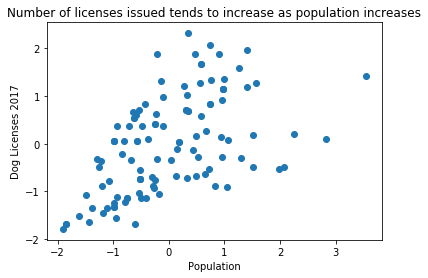

In [44]:
X_train = df_clustering[['Pop', 'DOG', 'NumVenues']].copy() 
scaler = StandardScaler()
X_train[['Pop', 'DOG', 'NumVenues']] = scaler.fit_transform(X_train[['Pop', 'DOG', 'NumVenues']])

plt.scatter(X_train['Pop'], X_train['DOG'])

plt.title("Number of licenses issued tends to increase as population increases")
plt.xlabel("Population")
plt.ylabel("Dog Licenses 2017")
plt.show()

In [45]:
pearson_coef, p_value = stats.pearsonr(df_clustering['Pop'], df_clustering['DOG'])
print("Generally as population increases, total pets increase. These values have a moderate positive correlation.")
print("Pearson coeff: ",pearson_coef,"P Value: ",p_value)

Generally as population increases, total pets increase. These values have a moderate positive correlation.
Pearson coeff:  0.5338438015460802 P Value:  1.1378075283012992e-09


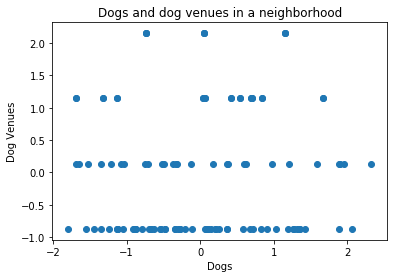

In [46]:
plt.scatter( X_train['DOG'],X_train['NumVenues'])
plt.title("Dogs and dog venues in a neighborhood")
plt.xlabel("Dogs")
plt.ylabel("Dog Venues")
plt.show()

When plotting the number of dogs against the number of dog walking venues, the relationship is not as clear.  There are neighborhoods with a larger number of dogs and a small number of venues to walk them.  We will avoid these neighborhoods for our business.

In [47]:
X_train.corr()

Pop       DOG  NumVenues
Pop        1.000000  0.533844  -0.206125
DOG        0.533844  1.000000   0.073937
NumVenues -0.206125  0.073937   1.000000

We can see in the above chart that our interpretation of the scatter plots was correct- the population to dog correlation is positive and moderate (.53) and the correlation between dogs and number of places to walk them is very weak (.07).  Also notice there is a weak negative correlation between the population and the number of parks/trails/dog runs in a neighborhood (-.2).

Now we need to determine how many clusters we should divide the neighbourhoods into. Let's use the visual Elbow method.

We'll cluster using 1 to 20 clusters and get the scores (the sum of distances of samples to their closest cluster center) in a list.

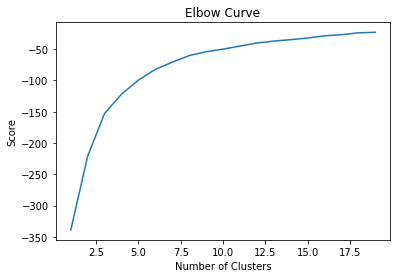

In [48]:
num_clusters = range(1, 20)

kmeans = [KMeans(n_clusters=i) for i in num_clusters]

score = [kmeans[i].fit(X_train).score(X_train) for i in range(len(kmeans))]
plt.plot(num_clusters, score)
plt.xlabel('Number of Clusters')

plt.ylabel('Score')

plt.title('Elbow Curve')

plt.show()

Looks like the elbow is around 7 clusters, so let's use that and re-run KMeans to get our Clusters

In [50]:
# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X_train)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[20:30] 

# add clustering labels back to our original data set
df_clustering['Cluster Labels'] = kmeans.labels_

df_clustering.head()

Postcode       Borough                                Neighborhood  \
0      M4L  East Toronto               The Beaches West,India Bazaar   
1      M8V     Etobicoke  Humber Bay Shores,Mimico South,New Toronto   
2      M4C     East York                            Woodbine Heights   
3      M4E  East Toronto                                 The Beaches   
4      M6P  West Toronto                High Park,The Junction South   

    Latitude  Longitude      Pop   DOG  Neighborhood Latitude  \
0  43.668999 -79.315572  32640.0  1315              43.668999   
1  43.605647 -79.501321  37975.0  1235                    NaN   
2  43.695344 -79.318389  46866.0  1201              43.695344   
3  43.676357 -79.293031  25044.0  1181              43.676357   
4  43.661608 -79.464763  40035.0  1179              43.661608   

   Neighborhood Longitude              Venue  Venue Latitude  Venue Longitude  \
0              -79.315572      Woodbine Park       43.664860       -79.315109   
1                     NaN                NaN             NaN              NaN   
2              -79.318389   Stan Wadlow Park       43.697836       -79.314303   
3              -79.293031  Glen Manor Ravine       43.676821       -79.293942   
4              -79.464763     Lithuania Park       43.658667       -79.463038   

  Venue Category PropTotal PerCapitaTotal  NumVenues  Cluster Labels  
0           Park   1.95991       0.040288          1               3  
1            NaN   1.84067      0.0325214          0               3  
2           Park      1.79      0.0256263          1               3  
3          Trail   1.76019       0.047157          1               3  
4           Park   1.75721      0.0294492          1               3

In [51]:
# create map to visualize the clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

df_clustering=df_clustering.dropna()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_clustering['Neighborhood Latitude'], df_clustering['Neighborhood Longitude'], df_clustering['Neighborhood'], df_clustering['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h3>Exploring the Clusters</h3>
<p>Let's get the average of each category for each cluster so we can compare them.</p>


In [54]:
cluster_summary=df_clustering.groupby(['Cluster Labels'], as_index=False)[['Cluster Labels','DOG','Pop','NumVenues']].agg('mean')
cluster_summary.sort_values('NumVenues', ascending=False, inplace=True)
cluster_summary

Cluster Labels          DOG  NumVenues           Pop
4               4   368.142857   2.428571  15479.642857
2               2   834.882353   2.176471  32312.588235
0               0   433.000000   1.000000  54680.000000
1               1   270.272727   1.000000  13287.727273
3               3  1154.666667   1.000000  36853.000000
5               5   525.333333   1.000000  33559.333333
6               6   729.666667   1.000000  22992.000000

We can see that clusters 4 and 2 have the largest number of dog walking venues, but cluster 2 has twice as many dogs on average as cluster 4.

Let's see our clusters of interest on a map.

In [56]:
clusters_of_interest = df_clustering[(df_clustering['Cluster Labels'] ==2) | 
                                                  (df_clustering['Cluster Labels'] == 4)]

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(3)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow[0] = '#e7298a'
rainbow[3] = '#6b6ecf'
#rainbow[7] = '#17becf'
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(clusters_of_interest['Neighborhood Latitude'], clusters_of_interest['Neighborhood Longitude'], clusters_of_interest['Neighborhood'], clusters_of_interest['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


<h2 id="Results-">Results <a name="results" /><a class="anchor-link" href="#Results-">&#182;</a></h2>

Dog Ownership in Toronto 2017:
* Highest pet ownership rates are in: East Toronto (M4L) and Etobicoke (M8V)
* Lowest pet ownership rates are in: Downtown toronto (M5H) and East York (M4H)

Dog Walking Venues
* The largest number of parks, trails and dog runs in any neighborhood is 3.  The following neighborhoods have 3 venues for walking a dog:
    * Rosedale (M4W)
    * Harbourfront,Regent Park (M5A)
    * Cabbagetown,St. James Town (M4X)


<h3>Candidates for dog walking location</h3>

We identified 2 clusters that appear like good candidates for a dog walking business.
* these areas have 
    * High pet ownership
    * High number of places to walk a dog
* Within these clusters, 2 FSAs jump out as particularly ideal for our purposes
    * M5A (Harbourfront,Regent Park) with 949 dogs and 3 walking venues
    * M4J (East Toronto) with 1110 dogs and 2 walking venues

<h2 id="Discussion-">Discussion <a name="discussion" /><a class="anchor-link" href="#Discussion-">&#182;</a></h2>

<h3>Caveats</h3>
Looking at the map, East Toronto (M4J) is relatively isolated whereas Harbourfront,Regent Park (M5A) has other neighborhoods in clusters 2 and 4 nearby.  Next time we could add latitude and longitude values into the clustering to look for neighborhoods that are close to each other.

Not all parks allow dogs.  I was not able to find data on which Toronto parks allow dogs.  This information would be helpful for getting a more accurate estimate of dog walking venues.

Also, since we don't have a way to accurately measure actual numbers of pets living in Toronto, I'm using newly issued licenses as a proxy. 
But this may not be a perfect measure since 
1) not every owner registers their dog 
2) dogs in certain neighborhoods may be registered at lower rates due to income 

<h3>Recommendations</h3>
My recommendation would be to target Harbourfront,Regent Park (M5A) when looking for a location to open a dog walking business.

This area has  
    * A large number of registered dogs
    * A high number of venues nearby for walking dogs
    * Proximity to other neighborhoods with these qualities

<h2 id="Conclusion-">Conclusion<a name="conclusion" /><a class="anchor-link" href="#Conclusion-">&#182;</a></h2>

In this project, I wanted to identify areas in Toronto that might be good candidates for centering a dog walking business.  Data was collected from a number of sources including open data portals, API calls and website scraping. This data provided a picture about the various Toronto neighbourhoods, including population, number of new dog licenses issued and number of venues for walking a dog.  Based on this data, I used the KMeans algorithm to cluster and identify areas that had high population, a high number of dog licenses and a high number of locations to walk a dog. 

This analysis suggested 2 clusters of locations, and within these I would recommend focusing on M5A, the Harbourfront,Regent Park area of Toronto.
